# Classificador Baseado no Grafo de Gabriel

## Importes de pacotes utilizados e Definição de Funções Auxiliares

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import warnings
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn import datasets
from collections import Counter
from os.path import exists
import pickle
import heapq
warnings.filterwarnings("ignore")

In [2]:
def plot_decision_border(X, y, clf):
    fig = plt.figure(figsize=(11,5))
    ax = fig.add_subplot(121)
    # decision surface for logistic regression on a binary classification dataset
    min1, max1 = X[:, 0].min()-0.3, X[:, 0].max()+0.3
    min2, max2 = X[:, 1].min()-0.3, X[:, 1].max()+0.3
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat=(clf.predict(grid))
    yhat=np.array(yhat)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='RdBu', edgecolor='none')
    # create scatter plot for samples from each class
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu')
    plt.grid()
    
    # plot surface:
    ax = fig.add_subplot(122, projection='3d')
    #create grid to evaluate model
    x = np.linspace(min1, max1, 30)
    y = np.linspace(min2, max2, 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    Z = clf.predict(xy).reshape(X.shape)
    Z=np.array(Z).reshape(X.shape)
    # plot decision boundary and margins
    figure = ax.plot_surface(X, Y, Z,rstride=1, cstride=1, cmap='RdBu',edgecolor='none')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    cbar = fig.colorbar(figure, ax=ax, extend='both')
    cbar.minorticks_on()
    plt.show()
    #plt.show() 

## Imprementação do Grafo de Gabriel 

In [3]:
# Code adapted from https://github.com/cran/GGClassification/blob/master/src/GGClassification_gabriel_graph.cpp
# References for this method can be found in L.C.B. Torres et al. (2015) <doi:10.1049/el.2015.1644>
def gabrielgraph(X):
    n = len(X)
    fourth_power_distance_array = np.zeros((n,n), dtype='float32')
    for i in range(n):
        fourth_power_distance_array[:,i] = np.sum((X-X[i])**2,axis=1) # vectorized fourth power distance of col(i)
        fourth_power_distance_array[i,i] = np.inf # convention: distance between same point is infinity

    array_of_adjacency = np.zeros((n,n), dtype='uint8')
    for i in range(n):
        for j in range(i+1,n):
            min_sum_of_distances = np.min(fourth_power_distance_array[i,:] + fourth_power_distance_array[j,:])
            # if the sum of the minimum distances between other points to i and j isn't
            # less or equal to the distance between i and j, then (i,j) is an edge that belongs to the graph.
            if min_sum_of_distances > fourth_power_distance_array[i,j]:
                array_of_adjacency[i,j] = 1
                array_of_adjacency[j,i] = 1
    return fourth_power_distance_array, array_of_adjacency

## Classificador de Classe Única Baseado no Grafo de Gabriel

In [4]:
# Code based on from https://github.com/cran/GGClassification/
# References for this method can be found in L.C.B. Torres et al. (2015) <doi:10.1049/el.2015.1644>
def euclidean_pair_distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

def euclidean_dist(X, x):
    return (np.sum((X-x)**2,axis=1))

class OCGG:
    def __init__(self, gamma=0) -> None:
        self.gamma = gamma

    def gg(self, X: np.ndarray) -> None:
        self.dist, adj = gabrielgraph(X)
        return adj

    def fit(self, X: np.ndarray) -> None:
        adj = self.gg(X)
        self.X_train = X
        Dg = adj * self.dist 
        Dg[np.isnan(Dg)] = 0
        Dl = []
        for i in range(Dg.shape[0]):
            for j in range(i):
                if Dg[i, j] != 0:
                    Dl.append(Dg[i, j])
        Nl = len(Dl)
        Dl = np.array(Dl)
        beta = Dl.sum()/Nl
        std = Dl.std()
        pos = int(self.gamma * Nl)
        if pos == 0:
            pos=1
        self.L = Dl[heapq.nlargest(pos, range(Dl.shape[0]), Dl.take)[-1]]
        #self.L = beta + (self.gamma*std)
        
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        y_hat = np.ones(X_test.shape[0])
        for i in range(X_test.shape[0]):
            dist = euclidean_dist(self.X_train, X_test[i,:])
            if min(j for j in dist if j > 0) > self.L:
                y_hat[i] = -1
        return y_hat

## Aplicação a Data Sets Sintéticos

### Base de Dados Circles

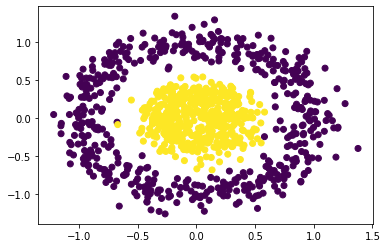

In [5]:
X, y = datasets.make_circles(n_samples=1000, noise=0.13, factor=0.3, random_state=2)
y[y==2] = 0
plt.scatter(X[:,0], X[:,1], c=y)

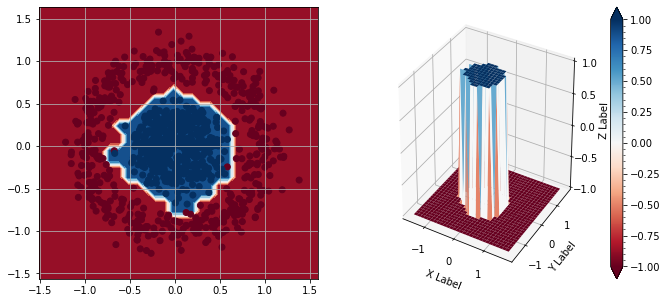

In [6]:
X_class1 = X[y==1, :]
clf=OCGG(0.05)
clf.fit(X_class1)
#X = X_test
y_hat = clf.predict(X)
plot_decision_border(X, y, clf)

### Base de Dados Moons

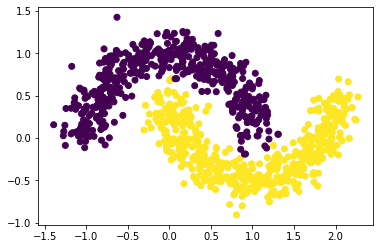

In [7]:
X, y = datasets.make_moons(n_samples=1000, noise=0.13, random_state=1)
y[y==2] = 0
plt.scatter(X[:,0], X[:,1], c=y)

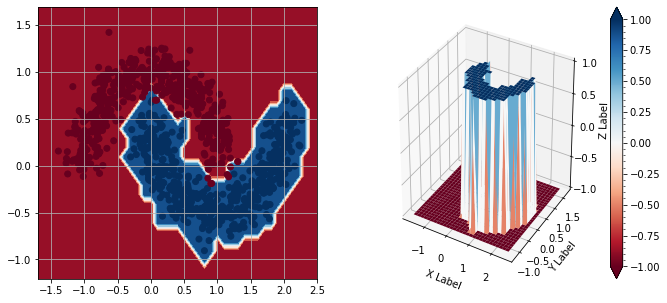

In [8]:
X_class1 = X[y==1, :]
clf=OCGG(0.05)
clf.fit(X_class1)
#X = X_test
y_hat = clf.predict(X)
plot_decision_border(X, y, clf)

### Base de Dados Spirals

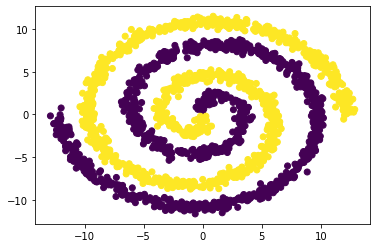

In [19]:
n_points = 2000
np.random.seed(1)
noise=.5
n_points = np.round(n_points/2).astype('int')
n = np.sqrt(np.random.rand(n_points,1)) * 720 * (2*np.pi)/360   # 720
d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
X1 = np.hstack((d1x,d1y))
X2 = np.hstack((-d1x,-d1y))
y1 = np.zeros(n_points)
y2 = np.ones(n_points)
X2 = X2 + np.random.randn(n_points, 2)*0.3
X1 = X1 + np.random.randn(n_points, 2)*0.3
X = np.vstack((X1,X2))
y = np.hstack((y1,y2))
plt.scatter(X[:,0], X[:,1], c=y)

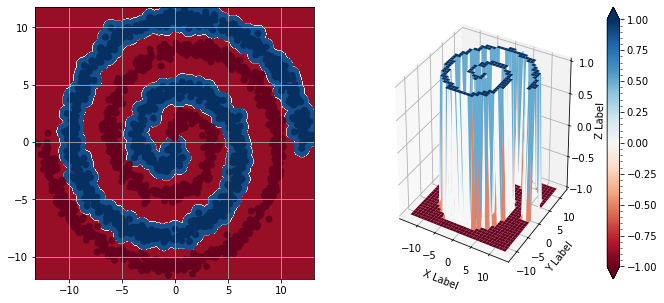

In [21]:
X_class1 = X[y==1, :]
clf=OCGG(0.05)
clf.fit(X_class1)
#X = X_test
y_hat = clf.predict(X)
plot_decision_border(X, y, clf)

### Base de Dados 2 Gaussians

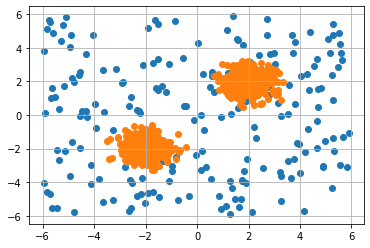

In [15]:
n_samples = 1000
outliers_fraction = 0.2
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
X, y = datasets.make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)
y[y==0] = 1
rng = np.random.RandomState(42)
X = np.concatenate([rng.uniform(low=-6, high=6, size=(n_outliers, 2)), X], axis=0)
y = np.concatenate([np.zeros(n_outliers), y])
for class_value in [0, 1]:
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
plt.grid()

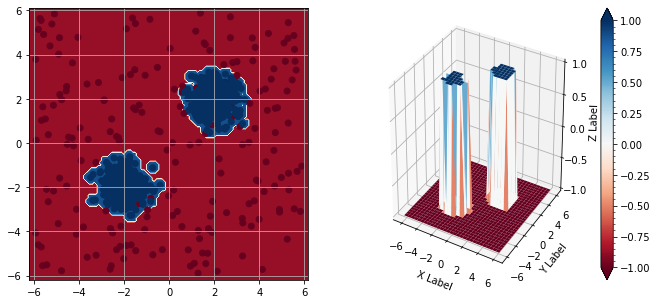

In [18]:
X_class1 = X[y==1, :]
clf=OCGG(0.05)
clf.fit(X_class1)
#X = X_test
y_hat = clf.predict(X)
plot_decision_border(X, y, clf)

### Base de Dados Corners

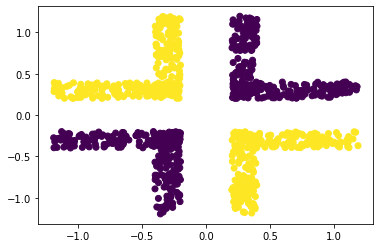

In [13]:
data = pd.read_csv('data/corners/corners.csv').to_numpy()
X = data[:, 0:2]
y = data[:, 2]
y[y==1] = 0
y[y==2] = 1
y[y==3] = 1
plt.scatter(X[:,0], X[:,1], c=y)

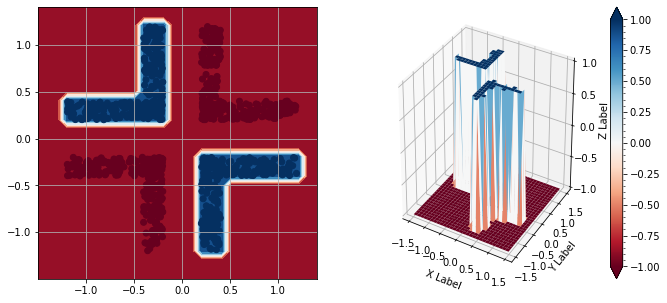

In [14]:
X_class1 = X[y==1, :]
clf=OCGG(0.05)
clf.fit(X_class1)
#X = X_test
y_hat = clf.predict(X)
plot_decision_border(X, y, clf)